In [26]:
from keras.preprocessing.sequence import pad_sequences

from collections import defaultdict, Counter
import os
import gzip
import re
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

In [3]:
np.random.seed(42)

In [4]:
path2data = 'GDI-official-training-data/GDI-TRAIN.txt.gz'
folds_json = 'cv.d/folds.json'
# save all the preprocessed data
data_dir = 'preprocessed_data.d/paper_runs/'

In [5]:
# read in data; each line is a sample \t label
data = []
targets = []
# target encoder
label_encoder = {'LU':0, 'BE':1, 'ZH':2, 'BS':3}
with gzip.open(path2data, 'rt', encoding='utf8') as f:
    for line in f:
        d, t = line.split('\t')
        data.append(d)
        # encode targets
        targets.append(label_encoder[t.strip()])

In [6]:
targets = np.array(targets)

In [7]:
folds = json.load(open(folds_json))
test_idx = folds['test_idx']
# use 0th fold for train / dev split
train = folds['cv_idx'][0]
assert train['fold'] == 0
train_idx, val_idx = train['train_idx'], train['val_idx']

In [8]:
# lengths of train, dev
print(len(train_idx), len(val_idx))

11726 1304


### Character replacement that we use elsewhere

In [9]:
char_replacement = {u'é':u'e1', u'è':u'e2', u'ẽ':u'e3',
                    u'ò':u'o2', u'õ':u'o2',
                    u'ú':u'u1', u'ù':u'u2',
                    u'à':u'a2', u'ã':u'a3',
                    u'ǜ':u'ü2',
                    u'ì':u'i2',
                   }

def replace_ngraphs(s):
    for old, new in [('sch', '8'), ('ch', '9')]:
        s = s.replace(old, new)
    return s

def replaced(s):
    return ''.join(char_replacement.get(c, c) for c in replace_ngraphs(s))

In [10]:
### apply all replacements
print(data[3])
print(replaced(data[3]))

a das chamì natüürlich aus nìd erinnere
a das 9ami2 natüürli9 aus ni2d erinnere


### Data encoding

In [11]:
padding='pre'
truncating='post'

def encode_data(X, encoder,
                maxlen, fit=False,
                padding=padding,
                truncating=truncating,
                padding_value=0):
    # `fit=True` for training, `fit=False` otherwise
    # for production: better intelligently replace chars not in encoder
    return pad_sequences(([[encoder[c] for c in s] for s in X] if fit else
                          # in dev and test, if char not in encoder, ignore it
                          [[encoder[c] for c in s if c in encoder] for s in X]),
                         maxlen=maxlen, dtype='int32',
                         padding=padding, truncating=truncating,
                         value=padding_value)

# one-hot encode targets
def encode_targets(y, num_targets=len(label_encoder)):
    lt = len(y)
    y_enc = np.zeros((lt, num_targets))
    y_enc[range(lt), y] = 1
    return y_enc

def decoder(enc):
    return dict((v, k) for k, v in enc.items())

### Data augmentation

In [12]:
# augment training data & throw out short messages !
def augment_train(X, y,
                  ignore_short_messages=3,
                  double_long_messages=10,
                  triple_very_long_messages=15):
    X_ = []
    y_ = []
    for d, l in zip(X, y):
        s = d.split(' ')
        lt = len(s)
        if lt < ignore_short_messages:
            continue
        if lt >= triple_very_long_messages:
            offset = round(lt / 3)
            half_offset = round(lt / 6)
            s1 = ' '.join(s[:-offset])
            s2 = ' '.join(s[offset:])
            s3 = ' '.join(s[half_offset:-half_offset])
            # add three new sentences instead of the one old one
            X_.extend([s1, s2, s3])
            y_.extend([l, l, l])
        elif lt >= double_long_messages:
            offset = round(lt / 4)
            s1 = ' '.join(s[:-offset])
            s2 = ' '.join(s[offset:])
            # add two new sentences instead of the one old one
            X_.extend([s1, s2])
            y_.extend([l, l])
        else:
            X_.append(d)
            y_.append(l)
            
    return X_, y_

### Save variously encoded data

In [13]:
def save_data(model_dir, data_to_store):
    path = data_dir + model_dir
    
    if not os.path.exists(path):
        os.makedirs(path)
        
    for d, fn in data_to_store:
        np.savetxt(os.path.join(path, fn + '.txt'),
                   d, fmt='%d')

In [14]:
def encode_store(maxlen,
                 model_dir=False):
    
    # one hot encode characters
    encoder = defaultdict()
    encoder.default_factory = encoder.__len__
    padding_value = encoder['#']
    assert padding_value == 0
    
    # encoder data
    # prepend with a padding value, truncate long sequences at the end
    X_train_enc = encode_data(X_train, encoder, maxlen, fit=True)
    encoder = dict(encoder)
    print('# chars %d' % len(encoder))

    X_dev_enc = encode_data(X_dev, encoder, maxlen)
    X_test_enc = encode_data(X_test, encoder, maxlen)
    print('X_train / X_dev / X_test shapes:\n',
          X_train_enc.shape, X_dev_enc.shape, X_test_enc.shape)
    
    # encode targets
    y_train_enc = encode_targets(y_train)
    y_dev_enc = encode_targets(y_dev)
    y_test_enc = encode_targets(y_test)

    print('y_train / y_dev / y_test shapes:\n',
          y_train_enc.shape, y_dev_enc.shape, y_test_enc.shape)

    if model_dir:
        # store encoded data
        save_data(model_dir, ((X_train_enc, 'X_train'),
                              (X_dev_enc, 'X_dev'),
                              (X_test_enc, 'X_test'),
                              #
                              (y_train_enc, 'y_train'),
                              (y_dev_enc, 'y_dev'),
                              (y_test_enc, 'y_test')))
        
    return {'X' : (X_train_enc, X_dev_enc, X_test_enc),
            'y' : (y_train_enc, y_dev_enc, y_test_enc),
            'enc' : encoder}

### Check that data models work

In [15]:
test_models = True

if test_models:
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.linear_model import SGDClassifier
    from sklearn.metrics import accuracy_score

    def dec_X(X, dec):
        return [''.join([dec[c] for c in s if c]) for s in X]

    def dec_y(y):
        return y.nonzero()[1]

    def test_data_model(data_model):
        
        dec = decoder(data_model['enc'])

        X_train, X_dev, X_test = [dec_X(X, dec) for X in data_model['X']]
        y_train, y_dev, y_test = [dec_y(y) for y in data_model['y']]

        vec = CountVectorizer('content',
                              analyzer='char_wb',
                              ngram_range=(2, 7))
        clf = SGDClassifier()
        clf.fit(vec.fit_transform(X_train), y_train)

        y_dev_pred = clf.predict(vec.transform(X_dev))
        y_test_pred = clf.predict(vec.transform(X_test))

        print('Dev accuracy, test accuracy: ',
              accuracy_score(data_model['y'][1].nonzero()[1], y_dev_pred),
              accuracy_score(data_model['y'][2].nonzero()[1], y_test_pred))
else:
    def test_data_model(data_model):
        pass

### `model-charrep-augm`: No data augmentation, no char replacements

Below is how the data have been created / encoded for use with keras models.

In [16]:
# no char replacement or augmentation
X_train = [data[i] for i in train_idx]
y_train = targets[train_idx]

X_dev = [data[i] for i in val_idx]
y_dev = targets[val_idx]

X_test = [data[i] for i in test_idx]
y_test = targets[test_idx]

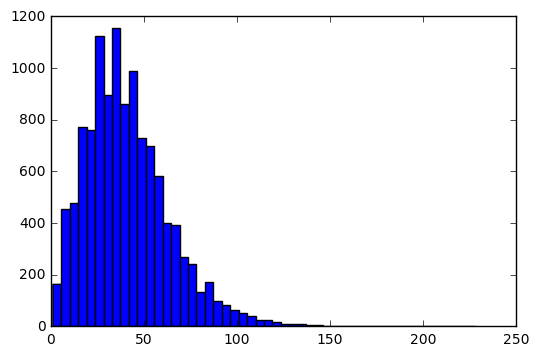

In [17]:
# decide on sequence lengths
plt.hist([len(s) for s in X_train], bins=50);

In [18]:
data_model = encode_store(maxlen=90,
                          model_dir='model-charrep-augm')
test_data_model(data_model)

# chars 45
X_train / X_dev / X_test shapes:
 (11726, 90) (1304, 90) (1448, 90)
y_train / y_dev / y_test shapes:
 (11726, 4) (1304, 4) (1448, 4)
Dev accuracy, test accuracy:  0.83282208589 0.82044198895


### `model+charrep-augm`: No data augmentation, WITH char replacements

Below is how the data have been created / encoded for use with keras models.

In [19]:
# char replacement, no augmentation
X_train = [replaced(data[i]) for i in train_idx]
y_train = targets[train_idx]

X_dev = [replaced(data[i]) for i in val_idx]
y_dev = targets[val_idx]

X_test = [replaced(data[i]) for i in test_idx]
y_test = targets[test_idx]

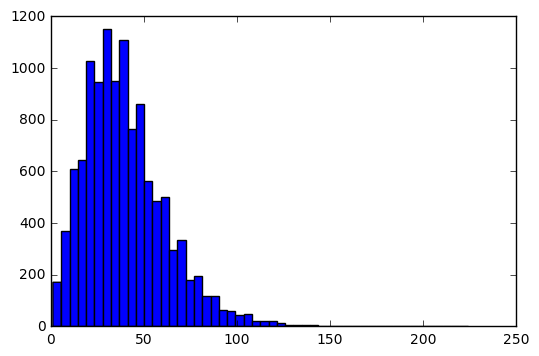

In [20]:
# decide on sequence lengths
plt.hist([len(s) for s in X_train], bins=50);

In [21]:
data_model = encode_store(maxlen=80,
                          model_dir='model+charrep-augm')
test_data_model(data_model)

# chars 39
X_train / X_dev / X_test shapes:
 (11726, 80) (1304, 80) (1448, 80)
y_train / y_dev / y_test shapes:
 (11726, 4) (1304, 4) (1448, 4)
Dev accuracy, test accuracy:  0.83282208589 0.828038674033


### `model-charrep+augm`: WITH data augmentation, no char replacements

Data augmentation means that the **training set**, but not the dev and test sets, gets augmented by newer sentences made out of short training sentences. Further, extra short sentences get thrown out of the training set.

Below is how the data have been created / encoded for use with keras models.

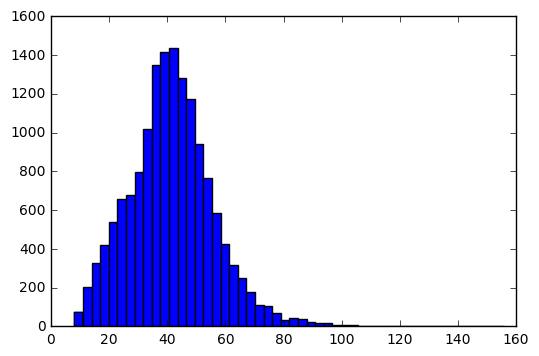

In [22]:
# no char replacement, with augmentation
X_train = [data[i] for i in train_idx]
y_train = targets[train_idx]
# data augmentation:
X_train, y_train = augment_train(X_train, y_train)

X_dev = [data[i] for i in val_idx]
y_dev = targets[val_idx]

X_test = [data[i] for i in test_idx]
y_test = targets[test_idx]

# decide on sequence lengths
plt.hist([len(s) for s in X_train], bins=50);

In [23]:
data_model = encode_store(maxlen=75,
                          model_dir='model-charrep+augm')
test_data_model(data_model)

# chars 44
X_train / X_dev / X_test shapes:
 (15340, 75) (1304, 75) (1448, 75)
y_train / y_dev / y_test shapes:
 (15340, 4) (1304, 4) (1448, 4)
Dev accuracy, test accuracy:  0.833588957055 0.841850828729


### `model+charrep+augm`: WITH data augmentation, WITH char replacements

Below is how the data have been created / encoded for use with keras models.

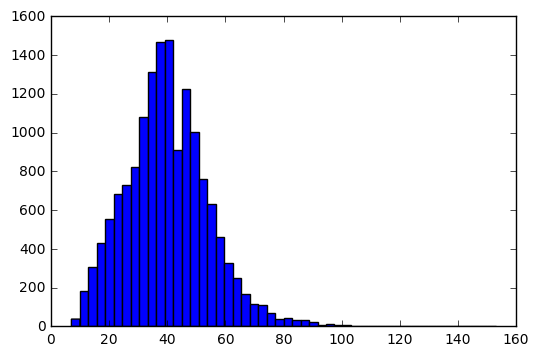

In [24]:
# no char replacement, with augmentation
X_train = [replaced(data[i]) for i in train_idx]
y_train = targets[train_idx]
# data augmentation:
X_train, y_train = augment_train(X_train, y_train)

X_dev = [replaced(data[i]) for i in val_idx]
y_dev = targets[val_idx]

X_test = [replaced(data[i]) for i in test_idx]
y_test = targets[test_idx]

# decide on sequence lengths
plt.hist([len(s) for s in X_train], bins=50);

In [25]:
data_model = encode_store(maxlen=70,
                          model_dir='model+charrep+augm')
test_data_model(data_model)

# chars 38
X_train / X_dev / X_test shapes:
 (15340, 70) (1304, 70) (1448, 70)
y_train / y_dev / y_test shapes:
 (15340, 4) (1304, 4) (1448, 4)
Dev accuracy, test accuracy:  0.831288343558 0.837016574586


### Run 1 and Ensemble Run 3

**Properties of these runs:**
   * character replacements applied,
   * short messages dropped: All of length 4 are less (sic!),
   * following 10-fold CV on full training data, the following hyper-params set:
       * all one-character words dropped,
       * features are frequency counts of within-word (?) character n-grams,
       * n-grams range from bigrams to 6-grams.
 
**Classifiers:**
   * Multinomial Naive Bayes classifier with add-one smoothing (run 1),
   * Linear SVM with alpha=0.0001 (one systems of the ensemble run 3).

In [149]:
# remove short messages
def ingore_short(X, ignore_short_messages=4):
    long_idx = []
    for i, s in enumerate(X):
        t = s.split(' ')
        lt = len(t)
        # throws out all short messages:
        # messages of this length do not appear in test data
        if lt > ignore_short_messages:
            long_idx.append(i)
    return long_idx

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, make_scorer

# folds are ordered
cv_idx = folds['cv_idx']
assert [f['fold'] for f in cv_idx] == list(range(10))

In [153]:
def generate_predictions(clf=MultinomialNB(),
                         analyzer='char',
                         ngram_range=(2,6),
                         ignore_short_messages=4):
    
    #print('Parameters: %s, analyzer="%s", ngram_range=%s, ignore_short_messages=%d'
    #      % (clf.__class__, analyzer, ngram_range, ignore_short_messages))

    long_idx = ingore_short(data,
                            ignore_short_messages=ignore_short_messages)
    # cv folds, each training set of which is filtered through long_idx
    cv = [(np.intersect1d(long_idx, f['train_idx']), f['val_idx']) for f in cv_idx]

    # character replacement
    X = [replaced(s) for s in data]
    
    # In this way, also vectorizer is refit every time,
    # i.e. vocabulary learned which affects testing.   
    pipeline = Pipeline([('vec', CountVectorizer(analyzer=analyzer,
                                                 ngram_range=ngram_range)),
                         ('clf', clf)])
    results = {'cv': []}
    # cross-validation predictions
    # not parallelized but still fast
    for train, test in cv:
        pipeline.fit([X[i] for i in train], targets[train])
        y_pred = pipeline.predict([X[i] for i in test])
        results['cv'].append(y_pred)

    # test predictions
    #
    # training data: all ids of the zeroth fold's training and
    # validation sets char-replaced and short sentences filtered out
    short_train = [i for ss in cv[0] for i in ss]  # dev set short sentences kept?...
    X_train = [X[i] for i in short_train]
    y_train = targets[short_train]

    X_test = [X[i] for i in test_idx]
    y_test = targets[test_idx]

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    results['test'] = y_pred
    return results

In [155]:
# report multiple metrics
def evaluate_en_masse(labels, # [(true, pred), ...]
                      metrics=[(accuracy_score, 'accuracy'),
                               (lambda y, y_pred: f1_score(y, y_pred, average='weighted'), 'weighted F1'),
                               (lambda y, y_pred: f1_score(y, y_pred, average='macro'), 'macro-avrg F1')]):
    results = dict((n, []) for _, n in metrics)
    for ll in labels:
        for metric, name in metrics:
            fold_result = metric(*ll)
            #print(name, fold_result)
            results[name].append(fold_result)
    return results

In [173]:
# true labels
y_test = [targets[folds['test_idx']]]
y_cv = [targets[f['val_idx']] for f in folds['cv_idx']]

def print_results(preds, names):
    for p, n in zip(preds, names):
        print('CV %s:' % n)
        out = evaluate_en_masse(zip(y_cv, p['cv']))
        for k, v in out.items():
            print(k, '%.4f (%.4f)' % (np.mean(v), np.std(v)))
        print('Test %s:' % n)
        out = evaluate_en_masse(zip(y_test, [p['test']]))
        for k, v in out.items():
            print(k, '%.4f' % v[0])
        print('\n\n')
        
# Run 3 is a majority-vote ensemble: If all classifiers disagree,
# return label by the classifier with index `fallback`
def ensemble(runs, fallback=0):
    preds = []
    for fold in zip(*runs):  # group by fold
        fold_preds = []
        for r in zip(*fold): # group by sample
            counts = Counter(r)
            classlabel, classcount = counts.most_common(n=1)[0]
            if classcount > 2:
                pred = r[fallback]
            else:
                pred = classlabel
            fold_preds.append(pred)
        preds.append(np.array(fold_preds))
    return preds

In [175]:
# run 1 and the SVM for run 3
preds = []
for params in [{'clf': MultinomialNB()},
               {'clf': SGDClassifier(alpha=0.001), 'analyzer': 'char'}]:
    p = generate_predictions(**params)
    preds.append(p)
    
# run 2 predictions: Read from file
run2_dir = 'run2_out_35_0.d/'
run2_preds = {'cv': []}
for i in range(10):
    with open(os.path.join(run2_dir, 'test_%d.prediction.tsv' % i)) as f:
        sr = csv.reader(f, delimiter='\t')
        fold = np.array([label_encoder[l] for l, in sr])
        run2_preds['cv'].append(fold)
        
with open(os.path.join(run2_dir, 'test_I.prediction.tsv')) as f:
    sr = csv.reader(f, delimiter='\t')
    pred_I = np.array([label_encoder[l] for l, in sr])
    run2_preds['test'] = pred_I
    
# run 3 predictions
run3_preds = {'cv' : ensemble([p['cv'] for p in preds] + [run2_preds['cv']]),
             'test': ensemble([[p['test']] for p in preds] + [[run2_preds['test']]])[0]}

# Results
print_results(preds + [run2_preds, run3_preds], ['NB', 'SVM', 'CRF', 'ENS'])

CV NB:
macro-avrg F1 0.8499 (0.0082)
accuracy 0.8510 (0.0082)
weighted F1 0.8510 (0.0082)
Test NB:
macro-avrg F1 0.8536
accuracy 0.8543
weighted F1 0.8544



CV SVM:
macro-avrg F1 0.8240 (0.0090)
accuracy 0.8252 (0.0097)
weighted F1 0.8248 (0.0096)
Test SVM:
macro-avrg F1 0.8234
accuracy 0.8232
weighted F1 0.8234



CV CRF:
macro-avrg F1 0.8387 (0.0070)
accuracy 0.8396 (0.0068)
weighted F1 0.8393 (0.0069)
Test CRF:
macro-avrg F1 0.8502
accuracy 0.8501
weighted F1 0.8501



CV ENS:
macro-avrg F1 0.8554 (0.0085)
accuracy 0.8567 (0.0086)
weighted F1 0.8565 (0.0086)
Test ENS:
macro-avrg F1 0.8557
accuracy 0.8564
weighted F1 0.8563



